In [7]:
# 1. Install standard libraries
!pip install awkward vector pytorch-lightning

# 2. Install vqtorch directly from GitHub
!pip install git+https://github.com/minyoungg/vqtorch.git

import torch
import vqtorch
print(f"vqtorch installed successfully.")
print(f"GPU Available: {torch.cuda.is_available()}")

  Cloning https://github.com/minyoungg/vqtorch.git to /tmp/pip-req-build-ggcf13_l
  Running command git clone --filter=blob:none --quiet https://github.com/minyoungg/vqtorch.git /tmp/pip-req-build-ggcf13_l
  Resolved https://github.com/minyoungg/vqtorch.git to commit 02e60a19bd742c17b0bf3e1925f23796d54cbeac
  Preparing metadata (setup.py) ... done
vqtorch installed successfully.
GPU Available: True


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_toy_jets(num_jets=1000, num_particles=30):
    # Arrays to hold our data and labels
    # x shape: [1000, 30, 3] (pT, eta, phi)
    # y shape: [1000] (0 or 1)
    x = torch.zeros(num_jets, num_particles, 3)
    y = torch.zeros(num_jets)

    for i in range(num_jets):
        # Decide if this jet is Signal (1) or Background (0)
        is_signal = i % 2 == 0

        if is_signal:
            y[i] = 1
            # Signal: Tight cluster (Small spread)
            # pT: Random energy
            # eta/phi: Centered at 0 with small variance (0.1)
            eta = np.random.normal(0, 0.1, num_particles)
            phi = np.random.normal(0, 0.1, num_particles)
            pt  = np.random.exponential(100, num_particles) # High energy core
        else:
            y[i] = 0
            # Background: Wide spray (Large spread)
            # eta/phi: Centered at 0 but huge variance (0.8)
            eta = np.random.normal(0, 0.8, num_particles)
            phi = np.random.normal(0, 0.8, num_particles)
            pt  = np.random.exponential(20, num_particles) # Lower energy spread

        # Fill the tensor
        x[i, :, 0] = torch.tensor(pt)
        x[i, :, 1] = torch.tensor(eta)
        x[i, :, 2] = torch.tensor(phi)

    # Shuffle the data so 0s and 1s are mixed
    indices = torch.randperm(num_jets)
    x = x[indices]
    y = y[indices]

    return x, y

# Generate the data
x, y = generate_toy_jets()

print("Toy Data Generated!")
print(f"Features Shape: {x.shape}")
print(f"Labels Shape:   {y.shape} (1 = Signal, 0 = Background)")

Toy Data Generated!
Features Shape: torch.Size([1000, 30, 3])
Labels Shape:   torch.Size([1000]) (1 = Signal, 0 = Background)


In [15]:
# Check the first jet's first 5 particles
print("--- Inspection of First Jet ---")
print(f"Feature values (first 30 particles):\n {x[0, :30, :]}")

# Check for reasonable max/min values to ensure physics makes sense
print(f"\nMax Value in Tensor: {x.max().item():.4f}")
print(f"Min Value in Tensor: {x.min().item():.4f}")

--- Inspection of First Jet ---
Feature values (first 30 particles):
 tensor([[ 1.1262e+02,  6.2242e-02,  3.4232e-02],
        [ 1.3120e+02, -2.3802e-01, -5.8099e-02],
        [ 1.4673e+02,  4.5344e-02, -1.7420e-01],
        [ 3.7935e+02, -2.0705e-01, -9.4054e-02],
        [ 3.3637e+01,  4.1354e-02,  5.4643e-02],
        [ 2.7660e+01,  7.8970e-02,  8.6339e-03],
        [ 1.2195e+02,  1.2681e-01, -9.3761e-02],
        [ 4.9230e+01, -1.3792e-01,  1.0667e-01],
        [ 8.9483e+01, -4.4309e-02, -1.1221e-01],
        [ 1.2293e+01,  1.1132e-01,  1.3022e-01],
        [ 1.3472e+01, -2.7946e-02,  1.2470e-01],
        [ 3.6165e+01,  3.4151e-02,  1.4392e-02],
        [ 6.4082e+01, -4.6438e-02,  1.0961e-01],
        [ 2.9748e+01,  9.2771e-03, -1.1897e-01],
        [ 1.3294e+02, -5.1222e-02,  1.3748e-01],
        [ 9.7493e+00, -9.0909e-02, -1.2073e-01],
        [ 1.9068e+02, -1.1217e-01, -1.1312e-01],
        [ 1.0080e+00,  1.1800e-01, -3.4469e-02],
        [ 6.2800e+01, -1.0615e-01, -6.0706e-02],

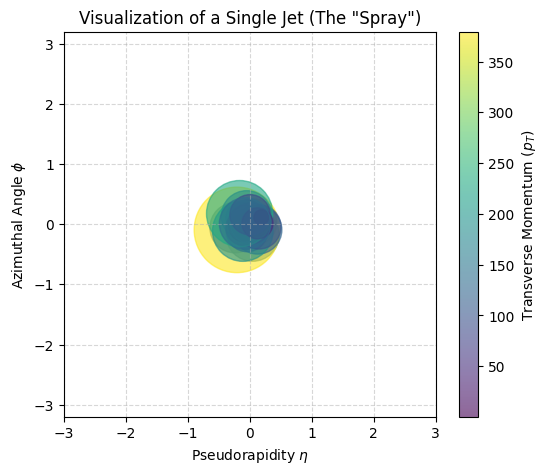

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first jet (index 0)
# Shape becomes [30, 3]
jet_data = x[0]

# Extract features
# pt is column 0, eta is column 1, phi is column 2
pt = jet_data[:, 0].cpu().numpy()
eta = jet_data[:, 1].cpu().numpy()
phi = jet_data[:, 2].cpu().numpy()

# Mask out the padding (zeros) so we don't plot them
mask = pt > 0
pt = pt[mask]
eta = eta[mask]
phi = phi[mask]

# Create the plot
plt.figure(figsize=(6, 5))
# Scale the size of the dots by pT so high energy particles look bigger
plt.scatter(eta, phi, s=pt*10, alpha=0.6, c=pt, cmap='viridis')

plt.xlabel(r'Pseudorapidity $\eta$')
plt.ylabel(r'Azimuthal Angle $\phi$')
plt.title('Visualization of a Single Jet (The "Spray")')
plt.colorbar(label='Transverse Momentum ($p_T$)')
plt.grid(True, linestyle='--', alpha=0.5)

# Fix axis limits to standard detector range if needed,
# typically eta is between -3 and 3, phi is -pi to pi.
plt.xlim(-3, 3)
plt.ylim(-3.2, 3.2)

plt.show()

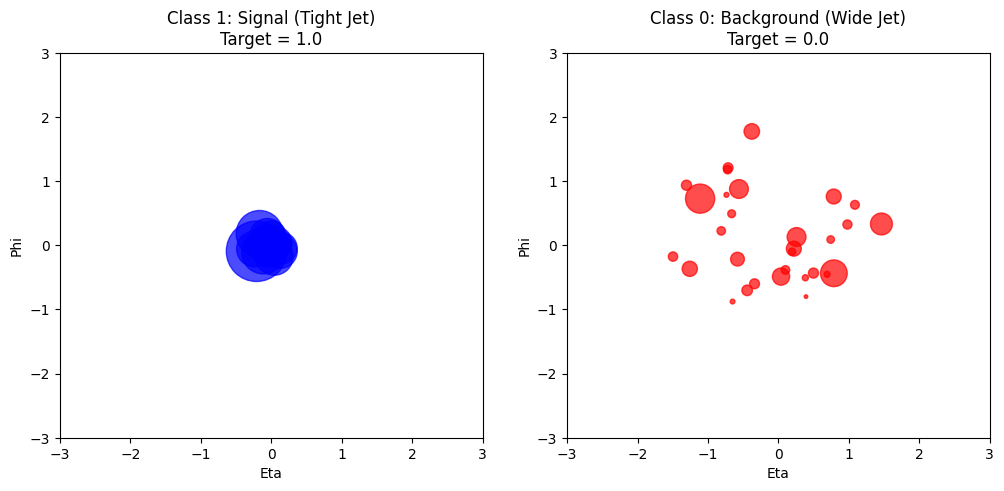

In [17]:
# Find one signal and one background index
sig_idx = (y == 1).nonzero(as_tuple=True)[0][0]
bkg_idx = (y == 0).nonzero(as_tuple=True)[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Signal
ax[0].scatter(x[sig_idx,:,1], x[sig_idx,:,2], s=x[sig_idx,:,0]*5, alpha=0.7, c='blue')
ax[0].set_title(f"Class 1: Signal (Tight Jet)\nTarget = {y[sig_idx]}")
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].set_xlabel("Eta"); ax[0].set_ylabel("Phi")

# Plot Background
ax[1].scatter(x[bkg_idx,:,1], x[bkg_idx,:,2], s=x[bkg_idx,:,0]*5, alpha=0.7, c='red')
ax[1].set_title(f"Class 0: Background (Wide Jet)\nTarget = {y[bkg_idx]}")
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel("Eta"); ax[1].set_ylabel("Phi")

plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# ==========================================
# 1. Define the "Deep Sets" Model
# ==========================================
class DeepSetsClassifier(nn.Module):
    def __init__(self, input_dim=3, latent_dim=64, output_dim=1):
        super(DeepSetsClassifier, self).__init__()

        # Phi Network: Looks at each particle individually
        # It learns "What does a single particle tell me?"
        self.phi = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU()
        )

        # Rho Network: Looks at the summed "Jet Info"
        # It learns "What does the whole cloud look like?"
        self.rho = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, output_dim) # Output: 1 number (Score)
        )

    def forward(self, x):
        # x shape: [Batch, 30 Particles, 3 Features]

        # 1. Apply Phi to every particle
        # We process all particles at once using PyTorch magic
        particle_feats = self.phi(x)
        # Shape is now: [Batch, 30, 64]

        # 2. Aggregation (The "Sum" Step)
        # We sum across the particle dimension (dim=1)
        # This makes the model "Permutation Invariant"
        jet_feats = torch.mean(particle_feats, dim=1)
        # Shape is now: [Batch, 64] (One vector per jet)

        # 3. Apply Rho to classify the jet
        out = self.rho(jet_feats)
        return out

# ==========================================
# 2. Setup Training
# ==========================================
# Initialize the model
model = DeepSetsClassifier()

# Define Loss Function (Binary Cross Entropy)
# "BCEWithLogits" is more stable than standard BCE
criterion = nn.BCEWithLogitsLoss()

# Define Optimizer (Adam is the standard choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)




# ==========================================
# PRE-PROCESSING FIX
# ==========================================

# 1. Normalize pT (Feature 0)
# We divide by the maximum value to squish it between 0 and 1
max_pt = x[:, :, 0].max()
x[:, :, 0] = x[:, :, 0] / max_pt

# 2. Normalize Eta/Phi (Features 1 and 2)
# We divide by 3 because we know they are usually within [-3, 3]
x[:, :, 1] = x[:, :, 1] / 3.0
x[:, :, 2] = x[:, :, 2] / 3.0

print(f"Data Normalized! Max pT is now: {x[:, :, 0].max().item():.2f}")

# Now re-run the split and training loop below...



# Split data into Train (800) and Test (200)
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split].unsqueeze(1)
x_test,  y_test  = x[train_split:], y[train_split:].unsqueeze(1)

# ==========================================
# 3. The Training Loop
# ==========================================
print("Starting Training...")
print("-" * 30)

num_epochs = 80 # How many times to loop through the data

for epoch in range(num_epochs):
    model.train() # Set to training mode

    # Forward pass: Compute predictions
    outputs = model(x_train)

    # Calculate error (Loss)
    loss = criterion(outputs, y_train)

    # Backward pass: Update weights
    optimizer.zero_grad() # Reset gradients
    loss.backward()       # Calculate gradients
    optimizer.step()      # Update weights

    # Print progress every 5 epochs
    if (epoch+1) % 5 == 0:
        # Calculate Accuracy on Test Data
        model.eval() # Set to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            predicted = (torch.sigmoid(test_outputs) > 0.5).float()
            accuracy = (predicted == y_test).float().mean()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item()*100:.1f}%')

print("-" * 30)
print("Training Complete.")

Data Normalized! Max pT is now: 1.00
Starting Training...
------------------------------
Epoch [5/80], Loss: 0.6910, Test Accuracy: 46.0%
Epoch [10/80], Loss: 0.6881, Test Accuracy: 98.5%
Epoch [15/80], Loss: 0.6832, Test Accuracy: 98.5%
Epoch [20/80], Loss: 0.6758, Test Accuracy: 100.0%
Epoch [25/80], Loss: 0.6631, Test Accuracy: 100.0%
Epoch [30/80], Loss: 0.6411, Test Accuracy: 100.0%
Epoch [35/80], Loss: 0.6106, Test Accuracy: 100.0%
Epoch [40/80], Loss: 0.5665, Test Accuracy: 100.0%
Epoch [45/80], Loss: 0.5040, Test Accuracy: 100.0%
Epoch [50/80], Loss: 0.4205, Test Accuracy: 100.0%
Epoch [55/80], Loss: 0.3210, Test Accuracy: 100.0%
Epoch [60/80], Loss: 0.2175, Test Accuracy: 100.0%
Epoch [65/80], Loss: 0.1272, Test Accuracy: 100.0%
Epoch [70/80], Loss: 0.0636, Test Accuracy: 100.0%
Epoch [75/80], Loss: 0.0290, Test Accuracy: 100.0%
Epoch [80/80], Loss: 0.0134, Test Accuracy: 100.0%
------------------------------
Training Complete.
